## Red Neuronal MultiCapa, OOP model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Importar Images

In [2]:
from get_images import get_images

In [7]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [8]:
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

In [9]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [10]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [11]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

### Graficar muestras

In [12]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 8


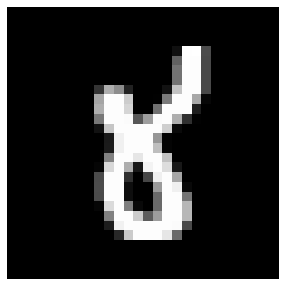

In [16]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [17]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [19]:
# Nos permite agregar atributos como el gradiente.
class np_tensor(np.ndarray): pass

###  Clase Linear

In [20]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size / 2)).view(np_tensor)
        # view(np_tensor), genera una vista del arreglo
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    
    # dunder __func__
    # Llama de forma automática esa función sin tener que escribirla.
    def __call__(self, X): # este es el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)
    

### Clase ReLU

In [22]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [21]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
        
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [23]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [24]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [26]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [27]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20


In [28]:
train(model, epochs, mb_size, learning_rate)

costo: 0.31428084971843534, accuracy: 0.9199
costo: 0.2240248227253503, accuracy: 0.939
costo: 0.27447825046722263, accuracy: 0.9468
costo: 0.1507111829618196, accuracy: 0.9536
costo: 0.1744406726408902, accuracy: 0.9578
costo: 0.11727143457038272, accuracy: 0.9597
costo: 0.09895815888976645, accuracy: 0.962
costo: 0.12852873932963313, accuracy: 0.9642
costo: 0.0948266430317151, accuracy: 0.9654
costo: 0.09820020120271636, accuracy: 0.9668
costo: 0.1244498539796802, accuracy: 0.9676
costo: 0.09439103703538418, accuracy: 0.9682
costo: 0.1157993710137003, accuracy: 0.9705
costo: 0.05488877674078158, accuracy: 0.97
costo: 0.06432565405238043, accuracy: 0.9694
costo: 0.053348733978357925, accuracy: 0.9715
costo: 0.06575550521357121, accuracy: 0.9714
costo: 0.06245073921654418, accuracy: 0.9723
costo: 0.08288523302286654, accuracy: 0.9715
costo: 0.06950276486642502, accuracy: 0.973


In [29]:
print(accuracy(x_test, y_test, mb_size))

0.9738


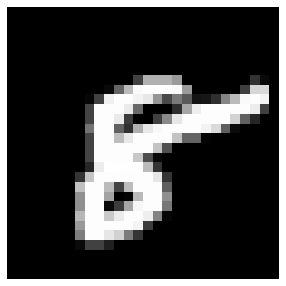

el valor predicho es: 8, el valor real es:8


In [62]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')